In [119]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("StudentMarksAnalysis") \
    .master("local[*]") \
    .getOrCreate()
spark

In [120]:
data = spark.read.csv(r"C:\Users\Chara\OneDrive\Desktop\4-1\BDA\SparkProject\MIDMARKS.csv", header=True)

In [94]:
print("Initial Data:")
data.show()

Initial Data:
+----+-------+---+----+---+----+---+----+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|
+----+-------+---+----+---+----+---+----+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|
|   5|  ALPHA| 18|  17| 19|  19| 20|  18|
|   6|  ALPHA| 17|  16| 18|  10| 15|   9|
|   7|  ALPHA| 15|  10| 20|  20| 15|  14|
|   8|  ALPHA| 17|  17| 19|  20| 19|  13|
|   9|  ALPHA| 10|  18|  A|  20| 19|  15|
|  10|  ALPHA| 18|  19| 20|  20| 20|  15|
|  11|  ALPHA| 17|  18| 20|  18| 20|  18|
|  12|  ALPHA| 20|  20| 20|  20| 19|  16|
|  13|  ALPHA| 16|  18| 11|  15| 19|  15|
|  14|  ALPHA| 17|  17| 18|  11| 15|   9|
|  15|  ALPHA| 19|  20| 20|  20| 18|  12|
|  16|  ALPHA| 13|  18| 17|  19| 16|   9|
|  17|  ALPHA| 15|  17| 18|  17| 17|  13|
|  18|  ALPHA| 11|   8| 18|  15| 19|  15|
|  19|  ALPHA| 14|  12| 16|  16| 20|  14|
|  20|  ALPHA| 19|  17| 20|  20| 20|  18|
+----+-------+---+--

In [95]:
print("Initial Schema:")
data.printSchema()

Initial Schema:
root
 |-- S.NO: string (nullable = true)
 |-- SECTION: string (nullable = true)
 |-- DV: string (nullable = true)
 |-- M-II: string (nullable = true)
 |-- PP: string (nullable = true)
 |-- BEEE: string (nullable = true)
 |-- FL: string (nullable = true)
 |-- FIMS: string (nullable = true)



Data Cleaning and Preprocessing

In [96]:
#Clean Subject Marks Column
from pyspark.sql.functions import col, when
subject_columns = ["DV", "M-II", "PP", "BEEE", "FL", "FIMS"]
for col_name in subject_columns:
    data = data.withColumn(
        col_name,
        when(col(col_name).isin("A", "AB", "MP", "o"), 0)
        .when(col(col_name).isNull(), 0)
        .otherwise(col(col_name).cast("int"))
    )
print("Schema after cleaning marks:")
data.printSchema()

Schema after cleaning marks:
root
 |-- S.NO: string (nullable = true)
 |-- SECTION: string (nullable = true)
 |-- DV: integer (nullable = true)
 |-- M-II: integer (nullable = true)
 |-- PP: integer (nullable = true)
 |-- BEEE: integer (nullable = true)
 |-- FL: integer (nullable = true)
 |-- FIMS: integer (nullable = true)



In [97]:
# Fill null values in SECTION
data = data.na.fill({"SECTION": "UNKNOWN"})
data = data.withColumn(
    "SECTION",
    when(col("SECTION") == "GAMA", "GAMMA")
    .when(col("SECTION") == "SGMA", "SIGMA")
    .otherwise(col("SECTION"))
)
print("Count per section after cleaning:")
data.groupBy("SECTION").count().orderBy("SECTION").show()

Count per section after cleaning:
+-------+-----+
|SECTION|count|
+-------+-----+
|  ALPHA|   60|
|   BETA|   60|
|  DELTA|   60|
|EPSILON|   60|
|  GAMMA|   60|
|  OMEGA|   60|
|  SIGMA|   60|
|UNKNOWN|   41|
|   ZETA|   19|
+-------+-----+



Calculate Total Marks, Percentage, and Grade

In [98]:
from pyspark.sql.functions import col, when, round
from functools import reduce
data = data.withColumn(
    "Total",
    reduce(lambda a, b: a + b, (col(c) for c in subject_columns))
)

In [99]:
data = data.withColumn("Percentage", round((col("Total") / 120) * 100, 2))

In [100]:
data = data.withColumn(
    "Grade",
    when(col("Percentage") >= 90, "A")
    .when(col("Percentage") >= 80, "B")
    .when(col("Percentage") >= 70, "C")
    .when(col("Percentage") >= 60, "D")
    .otherwise("F")
)

In [101]:
print("Data with new features (Total, Percentage, Grade):")
data.select("`S.NO`", "SECTION", "Total", "Percentage", "Grade").show()

Data with new features (Total, Percentage, Grade):
+----+-------+-----+----------+-----+
|S.NO|SECTION|Total|Percentage|Grade|
+----+-------+-----+----------+-----+
|   1|  ALPHA|   72|      60.0|    D|
|   2|  ALPHA|   84|      70.0|    C|
|   3|  ALPHA|  102|      85.0|    B|
|   4|  ALPHA|   94|     78.33|    C|
|   5|  ALPHA|  111|      92.5|    A|
|   6|  ALPHA|   85|     70.83|    C|
|   7|  ALPHA|   94|     78.33|    C|
|   8|  ALPHA|  105|      87.5|    B|
|   9|  ALPHA|   82|     68.33|    D|
|  10|  ALPHA|  112|     93.33|    A|
|  11|  ALPHA|  111|      92.5|    A|
|  12|  ALPHA|  115|     95.83|    A|
|  13|  ALPHA|   94|     78.33|    C|
|  14|  ALPHA|   87|      72.5|    C|
|  15|  ALPHA|  109|     90.83|    A|
|  16|  ALPHA|   92|     76.67|    C|
|  17|  ALPHA|   97|     80.83|    B|
|  18|  ALPHA|   86|     71.67|    C|
|  19|  ALPHA|   92|     76.67|    C|
|  20|  ALPHA|  114|      95.0|    A|
+----+-------+-----+----------+-----+
only showing top 20 rows



In [102]:
#Student Status (Pass/Fail/At-Risk)
from pyspark.sql.functions import lit

# Assume pass mark is 8 out of 20
pass_mark = 8
data = data.withColumn("Subjects_Failed",
    (when(col("DV") < pass_mark, 1).otherwise(0)) +
    (when(col("M-II") < pass_mark, 1).otherwise(0)) +
    (when(col("PP") < pass_mark, 1).otherwise(0)) +
    (when(col("BEEE") < pass_mark, 1).otherwise(0)) +
    (when(col("FL") < pass_mark, 1).otherwise(0)) +
    (when(col("FIMS") < pass_mark, 1).otherwise(0))
)

In [103]:
# Determine the status
data = data.withColumn(
    "Status",
    when(col("Subjects_Failed") == 0, "Pass")
    .when(col("Subjects_Failed").between(1, 2), "Needs Attention")
    .otherwise("Fail")
)
print("Data with new Status feature:")
data.select("`S.NO`", "Percentage", "Subjects_Failed", "Status").show()

Data with new Status feature:
+----+----------+---------------+---------------+
|S.NO|Percentage|Subjects_Failed|         Status|
+----+----------+---------------+---------------+
|   1|      60.0|              1|Needs Attention|
|   2|      70.0|              1|Needs Attention|
|   3|      85.0|              0|           Pass|
|   4|     78.33|              0|           Pass|
|   5|      92.5|              0|           Pass|
|   6|     70.83|              0|           Pass|
|   7|     78.33|              0|           Pass|
|   8|      87.5|              0|           Pass|
|   9|     68.33|              1|Needs Attention|
|  10|     93.33|              0|           Pass|
|  11|      92.5|              0|           Pass|
|  12|     95.83|              0|           Pass|
|  13|     78.33|              0|           Pass|
|  14|      72.5|              0|           Pass|
|  15|     90.83|              0|           Pass|
|  16|     76.67|              0|           Pass|
|  17|     80.83|   

In [104]:
# Add Math Skills category based on M-II marks
data = data.withColumn(
    "Math_Skills",
    when(col("M-II") >= 15, "Excellent")
    .when(col("M-II") >= 8, "Good")
    .otherwise("Poor")
)

In [105]:
# Add Performance Tier based on Percentage
data = data.withColumn(
    "Performance_Tier",
    when(col("Percentage") >= 80, "Top Performer")
    .when(col("Percentage") >= 50, "Average Performer")
    .otherwise("Needs Improvement")
)

In [106]:
print("Data with new Skill and Tier features:")
data.select("`S.NO`", "Percentage", "Math_Skills", "Performance_Tier").show()

Data with new Skill and Tier features:
+----+----------+-----------+-----------------+
|S.NO|Percentage|Math_Skills| Performance_Tier|
+----+----------+-----------+-----------------+
|   1|      60.0|       Poor|Average Performer|
|   2|      70.0|       Good|Average Performer|
|   3|      85.0|       Good|    Top Performer|
|   4|     78.33|       Good|Average Performer|
|   5|      92.5|  Excellent|    Top Performer|
|   6|     70.83|  Excellent|Average Performer|
|   7|     78.33|       Good|Average Performer|
|   8|      87.5|  Excellent|    Top Performer|
|   9|     68.33|  Excellent|Average Performer|
|  10|     93.33|  Excellent|    Top Performer|
|  11|      92.5|  Excellent|    Top Performer|
|  12|     95.83|  Excellent|    Top Performer|
|  13|     78.33|  Excellent|Average Performer|
|  14|      72.5|  Excellent|Average Performer|
|  15|     90.83|  Excellent|    Top Performer|
|  16|     76.67|  Excellent|Average Performer|
|  17|     80.83|  Excellent|    Top Performer|
|

In [107]:
from pyspark.sql.functions import col, when
data = data.withColumn(
    "Programming_Skills",
    when(col("PP") >= 15, "Excellent")
    .when(col("PP") >= 8, "Good")
    .otherwise("Poor")
)

In [108]:
#Display all columns
print("Complete Student Analysis Table:")
data.select(
    "`S.NO`",
    "SECTION",
    "DV",
    "`M-II`",
    "PP",
    "BEEE",
    "FL",
    "FIMS",
    "Total",
    "Percentage",
    "Grade",
    "Status",
    "Subjects_Failed",
    "Math_Skills",
    "Programming_Skills", 
    "Performance_Tier"
).show()

Complete Student Analysis Table:
+----+-------+---+----+---+----+---+----+-----+----------+-----+---------------+---------------+-----------+------------------+-----------------+
|S.NO|SECTION| DV|M-II| PP|BEEE| FL|FIMS|Total|Percentage|Grade|         Status|Subjects_Failed|Math_Skills|Programming_Skills| Performance_Tier|
+----+-------+---+----+---+----+---+----+-----+----------+-----+---------------+---------------+-----------+------------------+-----------------+
|   1|  ALPHA| 12|   0| 17|   9| 19|  15|   72|      60.0|    D|Needs Attention|              1|       Poor|         Excellent|Average Performer|
|   2|  ALPHA| 19|  12| 16|  16| 18|   3|   84|      70.0|    C|Needs Attention|              1|       Good|         Excellent|Average Performer|
|   3|  ALPHA| 18|  14| 18|  18| 18|  16|  102|      85.0|    B|           Pass|              0|       Good|         Excellent|    Top Performer|
|   4|  ALPHA| 15|   9| 19|  17| 19|  15|   94|     78.33|    C|           Pass|           

Exploratory Data Analysis & Visualization

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pandas_df = data.toPandas()

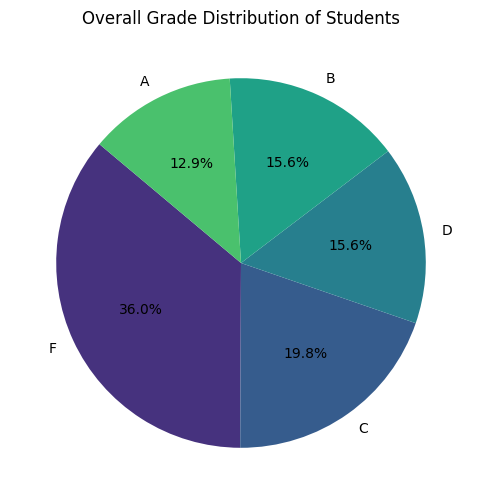

In [110]:
# Plot Grade Distribution
plt.figure(figsize=(10, 6))
grade_counts = pandas_df['Grade'].value_counts()
plt.pie(grade_counts, labels=grade_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
plt.title('Overall Grade Distribution of Students')
plt.ylabel('')
plt.show()

C:\Users\Chara\AppData\Local\Temp\ipykernel_10508\1835906177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Status', data=pandas_df, order=['Pass', 'Needs Attention', 'Fail'], palette='coolwarm')


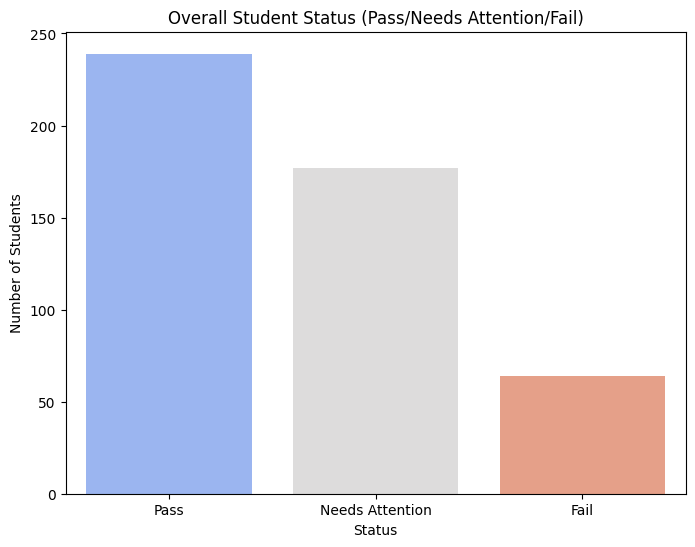

In [111]:
# Plot Status Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Status', data=pandas_df, order=['Pass', 'Needs Attention', 'Fail'], palette='coolwarm')
plt.title('Overall Student Status (Pass/Needs Attention/Fail)')
plt.xlabel('Status')
plt.ylabel('Number of Students')
plt.show()

C:\Users\Chara\AppData\Local\Temp\ipykernel_10508\3692129695.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=section_performance.index, y=section_performance.values, palette='plasma')


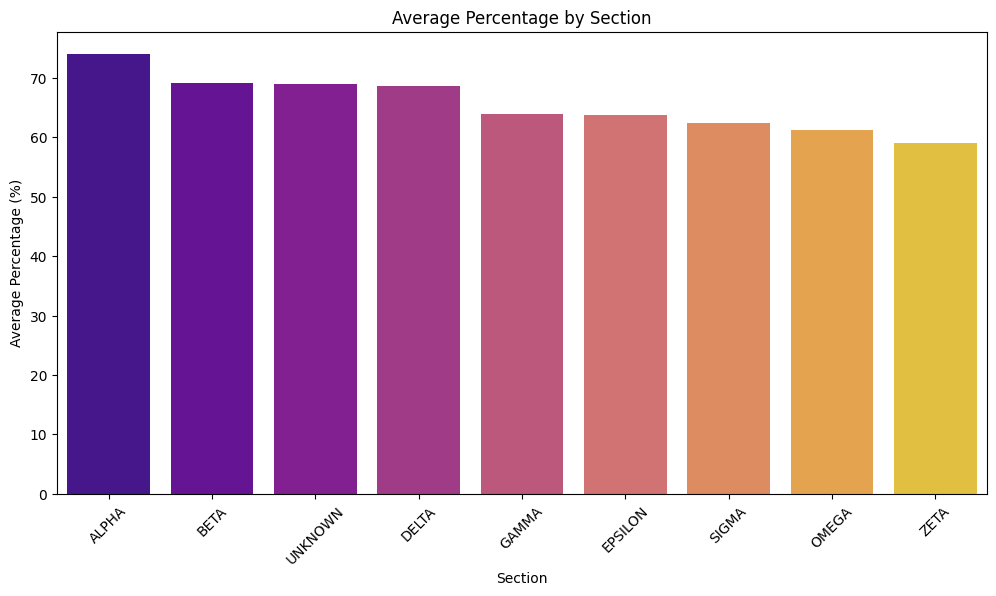

In [112]:
# Calculate and plot average percentage per section
section_performance = pandas_df.groupby('SECTION')['Percentage'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=section_performance.index, y=section_performance.values, palette='plasma')
plt.title('Average Percentage by Section')
plt.xlabel('Section')
plt.ylabel('Average Percentage (%)')
plt.xticks(rotation=45)
plt.show()

C:\Users\Chara\AppData\Local\Temp\ipykernel_10508\2072483074.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Subject', y='Pass_Percentage', data=subject_pass_df, palette='magma')


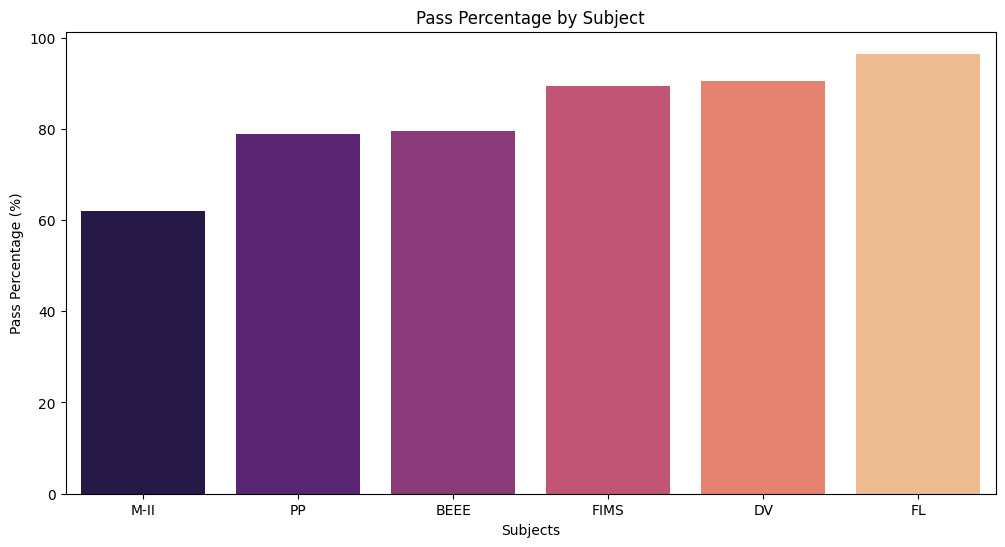

In [115]:
# Calculate pass percentage for each subjects
pass_percentages = {}
for subject in subject_columns:
    pass_count = pandas_df[pandas_df[subject] >= pass_mark].shape[0]
    total_students = pandas_df.shape[0]
    pass_percentages[subject] = (pass_count / total_students) * 100

subject_pass_df = pd.DataFrame(list(pass_percentages.items()), columns=['Subject', 'Pass_Percentage']).sort_values('Pass_Percentage')
plt.figure(figsize=(12, 6))
sns.barplot(x='Subject', y='Pass_Percentage', data=subject_pass_df, palette='magma')
plt.title('Pass Percentage by Subject')
plt.xlabel('Subjects')
plt.ylabel('Pass Percentage (%)')
plt.show()

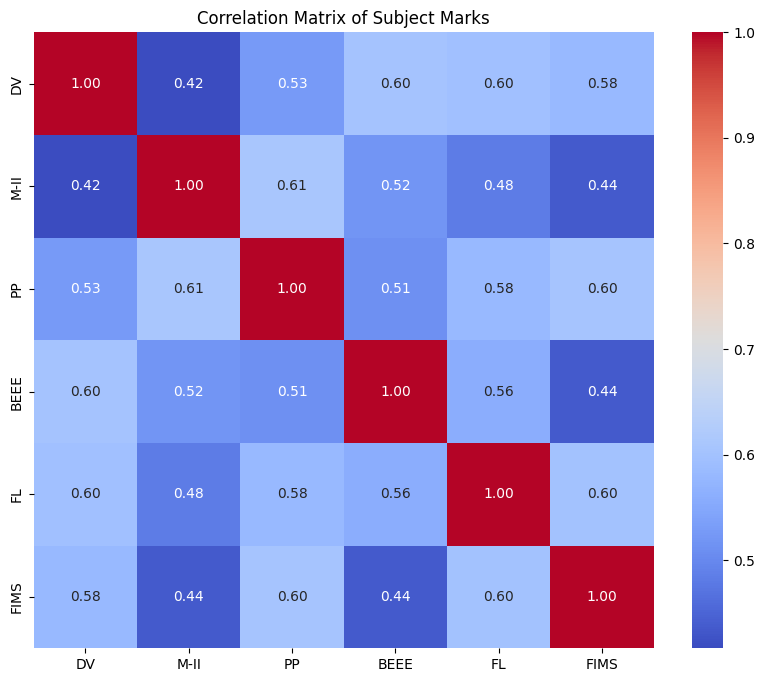

In [116]:
# Calculate and plot the correlation matrix
plt.figure(figsize=(10, 8))
corr = pandas_df[subject_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Subject Marks')
plt.show()

C:\Users\Chara\AppData\Local\Temp\ipykernel_10508\725824145.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x='Performance_Tier', palette='Set2', order=['Top Performer', 'Average Performer', 'Needs Improvement'])


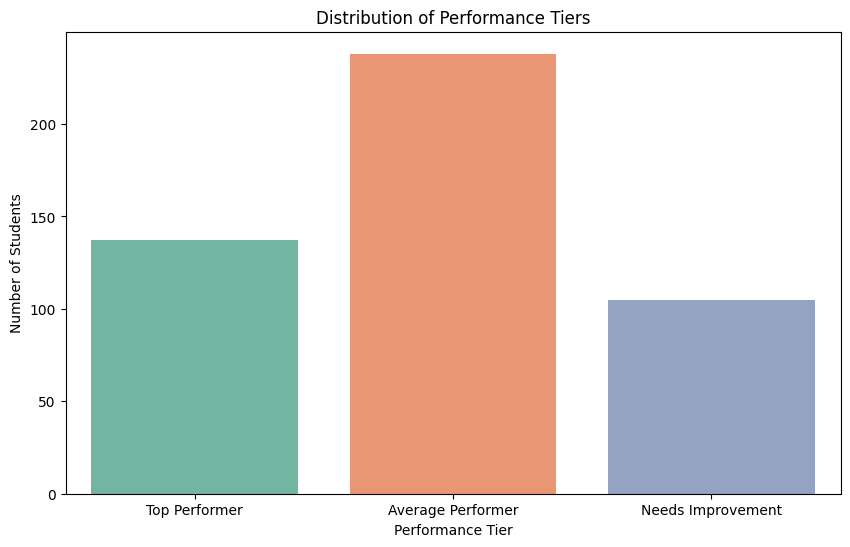

In [117]:
# Plot distribution of Performance Tiers
plt.figure(figsize=(10, 6))
sns.countplot(data=pandas_df, x='Performance_Tier', palette='Set2', order=['Top Performer', 'Average Performer', 'Needs Improvement'])
plt.title('Distribution of Performance Tiers')
plt.xlabel('Performance Tier')
plt.ylabel('Number of Students')
plt.show()

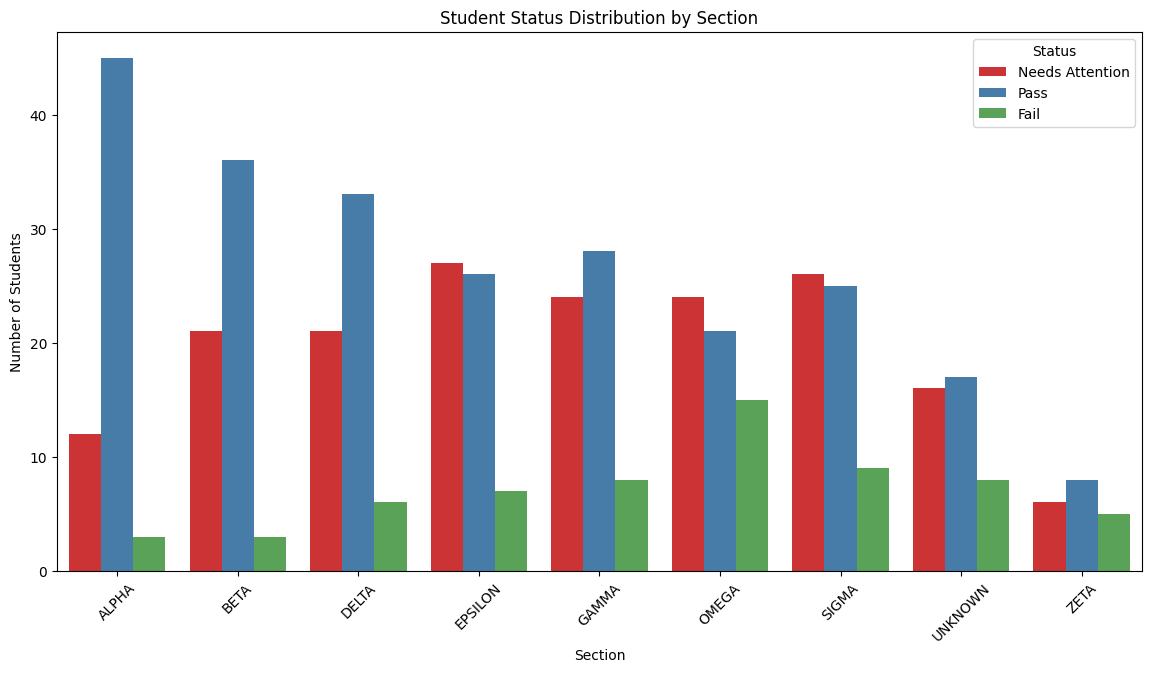

In [118]:
# Plot Status distribution across different Sections
plt.figure(figsize=(14, 7))
sns.countplot(data=pandas_df, x='SECTION', hue='Status', order=sorted(pandas_df['SECTION'].unique()), palette='Set1')
plt.title('Student Status Distribution by Section')
plt.xlabel('Section')
plt.ylabel('Number of Students')
plt.xticks(rotation=45)
plt.legend(title='Status')
plt.show()